# 실습[01]MLP-행렬곱구현
휴먼지능정보공학과 201910805 백서희

라이브러리 임포트

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms

MNIST test dataset 가져오기

In [2]:
#"":현재 폴더에 MINST있다는 의미
mnist_test=dset.MNIST("", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
#train=False -> test로 불러옴(test용으로 쓰겠다.)

대략적인 데이터 형태

In [3]:
print("mnist_test 길이:", len(mnist_test))

#데이터 하나 형태
image, label=mnist_test.__getitem__(0) #0번째 데이터

print("image data 형태:",image.size())
print("label:",label)

mnist_test 길이: 10000
image data 형태: torch.Size([1, 28, 28])
label: 7


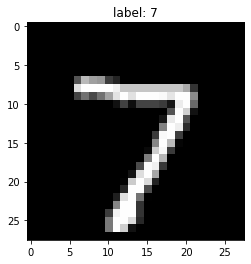

In [4]:
#그리기
img=image.numpy() #image 타입을 numpy로 변환 (1,28,28)
plt.title("label: %d" %label)
plt.imshow(img[0],cmap='gray')
plt.show()

sigmoid, softmax 함수 구현

In [5]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
#입력 값이 스칼라일 수도 있고, 벡터일 수도 있음 -> 여기에서는 벡터로 염두해둠
#엘리먼트 와이즈 연산으로 벡터의 각 원소에 시그모이드 함수를 씌워줌
#**for문을 이용하지 않는 것이 구현에서 중요함->벡터 연산을 위해 내부적으로 최적화된 함수를 쓰는 것이 중요(numpy에서 제공하는 함수 사용)

In [6]:
def softmax(x):
    e_x=np.exp(x) #벡터의 각 원소에 exponential 사용
    return e_x/np.sum(e_x) #np.sum()-각 원소를 합하는 함수

모델 선언

In [7]:
#Multi-layered perception
##of units in each layer: 28*28-256-128-10
class MyMLP:
    def __init__(self,n_input,n_hidden1,n_hidden2,n_output): #input layer, hidden layer1,2, output layer 개수
        #W^(1): layer1 > layer2 에 매핑되는 Weight
        self.W1=np.zeros((n_hidden1, n_input),dtype=np.float32) #Weight #W1(256,28*28)
        self.b1=np.zeros((n_hidden1,),dtype=np.float32) #Bias(따로 빼줌)

        self.W2=np.zeros((n_hidden2, n_hidden1),dtype=np.float32) #W2(128, 256) 257에서 bias 1개 뺌=256
        self.b2=np.zeros((n_hidden2,),dtype=np.float32)
        
        self.W3=np.zeros((n_output, n_hidden2),dtype=np.float32) #W3(10, 128)
        self.b3=np.zeros((n_output),dtype=np.float32)
        
    def __call__(self,x): #class에 해당하는 객체를 생성하고, 객체의 괄호 안에 입력값 x를 넣으면 자동으로 불러지는 부분
        #(1,28,28) -> (28*28)
        x=x.reshape(-1) #일렬로 피기
        
        h1=sigmoid(np.dot(self.W1, x)+self.b1) #W1(256, 28*28), x(28*28), b1(256) -> h1(256) #sigmoid는 activation function
        h2=np.dot(self.W2, h1)+self.b2 #W2(128, 256), h1(256), b2(128) -> h2(128)
        out=np.dot(self.W3, h2)+self.b3#W3(10, 128), h2(128), b3(10) -> out(10)
        
        return softmax(out) #(10) #0~1사이 10개 유닛의 값을 합치면 1이 되게끔 만들어줌

모델 생성

In [8]:
model=MyMLP(28*28,256,128,10)

print(model.W1.shape, model.b1.shape)
print(model.W2.shape, model.b2.shape)
print(model.W3.shape, model.b3.shape)

(256, 784) (256,)
(128, 256) (128,)
(10, 128) (10,)


미리 학습된 weight 로드

In [9]:
weight=np.load('mlp_weight.npz')

In [10]:
model.W1=weight['W1']
model.b1=weight['b1']
model.W2=weight['W2']
model.b2=weight['b2']
model.W3=weight['W3']
model.b3=weight['b3']

print(model.W1.shape, model.b1.shape)
print(model.W2.shape, model.b2.shape)
print(model.W3.shape, model.b3.shape)

(256, 784) (256,)
(128, 256) (128,)
(10, 128) (10,)


테스트

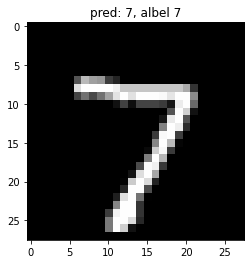

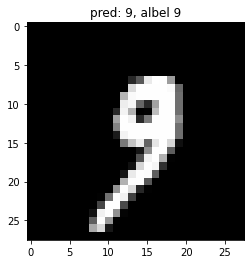

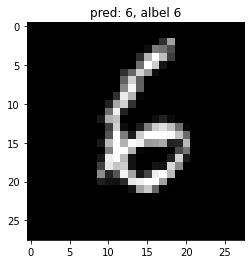

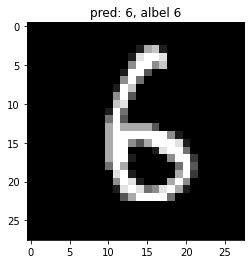

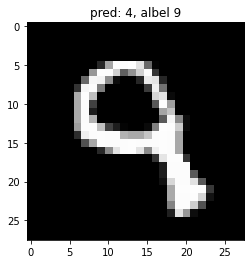

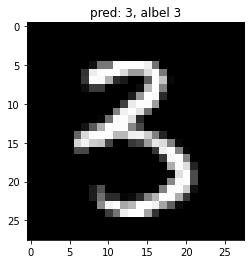

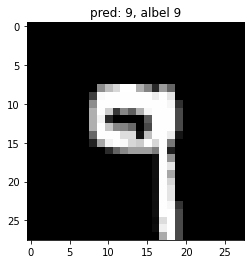

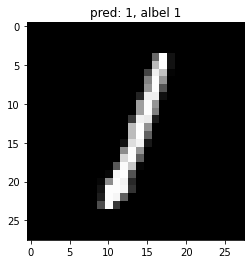

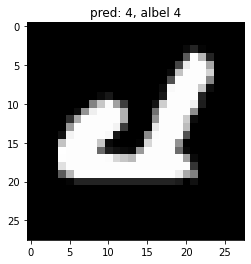

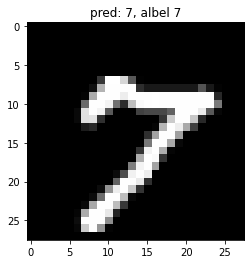

정확도: 91.91


In [11]:
mysum=0

m=len(mnist_test)
cnt=0

for i in range(m):
    image,label=mnist_test.__getitem__(i) #0번째 데이터
    output=model(image) #생성된 model에 image 넣어줌
    
    if(i%1000==0):
        img=image.numpy() #image 타입을 numpy로 변환 (1,28,28)
        pred_label=np.argmax(output) #argmax 함수- 배열 원소 중 max 값에 해당되는 인덱스를 리턴해주는 함수
        plt.title("pred: %d, albel %d" %(pred_label, label))
        plt.imshow(img[0],cmap='gray')
        plt.show()
    
    cnt+=1
    mysum+=(np.argmax(output)==label)#원 핫 인코딩 방식(0~9) #정답 label이 예측한 label과 같으면 1을 내보냄(mysum에 더해줌)
                                      #각 유닛의 원소값 중 가장 큰 값에 해당하는 유닛의 인덱스가 우리 모델이 예측한 label
print("정확도: %.2f" %((float(mysum)/cnt)*100.0))